In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("..")

In [2]:
from deepsvg.svglib.geom import Point, Angle
from deepsvg.svglib.svg import SVG
from deepsvg.svglib.utils import make_grid

# SVGLib walk-through

## Loading & displaying

In [32]:
dolphin = SVG.load_svg("./docs/imgs/Layer 2.svg")

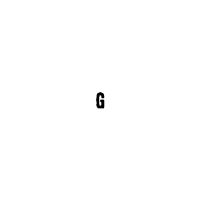

In [33]:
dolphin.draw()

For proper displaying, SVGlib expects SVGs to be drawn in a normalized viewbox of size 24x24. Stroke-width will appear to thin if a larger viewbox is used and too thick if the viewbox is too small.

In [34]:
print(dolphin.viewbox)

Bbox(0.0 0.0 612.0 792.0)


You can **normalize** an SVG with the `normalize` method which will properly scale the points to fit a 24x24 window.

Bbox(0.0 0.0 24.0 24.0)


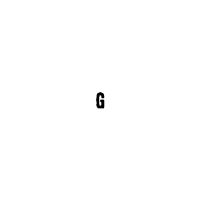

In [35]:
dolphin.normalize()
print(dolphin.viewbox)
dolphin.draw()

The `with_points` option lets you display the individual points of the path:

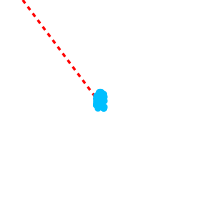

In [36]:
dolphin.draw(with_points=True)

Let us "unzoom" a little, so that there is a little more free room on the borders of the image.

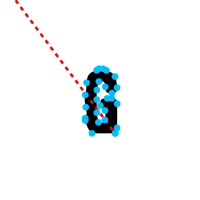

In [37]:
dolphin.zoom(4).draw(with_points=True)

For easier training of DeepSVG, the following "canonicalization" strategy is used:
- an SVG path is oriented clockwise and starts from the topmost-leftmost point.
- the path is simplified, so that points lie at approximately equal distance between each other.

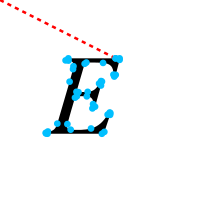

In [25]:
dolphin.canonicalize().draw(with_points=True)

Our simplification heuristic uses a combination of Ramer-Douglas-Peucker and Philip J. Schneider algorithms.

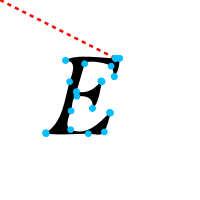

In [26]:
dolphin.simplify_heuristic().draw(with_points=True)

Finally, generating a GIF from the drawing is as easy as:

In [27]:
dolphin.animate(frame_duration=0.1)

TypeError: must be real number, not NoneType

## Distinguishing individual paths

In [38]:
svg = SVG.load_svg("docs/imgs/Layer 2.svg")
svg.zoom(4)

SVG[Bbox(0.0 0.0 612.0 792.0)](
	SVGPathGroup(SVGPath(M[P(-918.0, -1188.0), P(366.0, 528.0)] C[P(366.0, 528.0), P(335.33203125, 528.0), P(304.66796875, 528.0), P(274.0, 528.0)] C[P(274.0, 528.0), P(259.33203125, 514.1240234375), P(252.008056640625, 496.3599853515625), P(247.4200439453125, 477.239990234375)] C[P(247.4200439453125, 477.239990234375), P(246.6920166015625, 474.2080078125), P(246.080078125, 470.0999755859375), P(247.5120849609375, 467.77197265625)] C[P(247.5120849609375, 467.77197265625), P(256.296142578125, 453.468017578125), P(252.548095703125, 439.47998046875), P(249.488037109375, 424.3800048828125)] C[P(249.488037109375, 424.3800048828125), P(246.280029296875, 408.5479736328125), P(242.9320068359375, 390.64404296875), P(247.31201171875, 375.927978515625)] C[P(247.31201171875, 375.927978515625), P(252.1920166015625, 359.52392578125), P(252.0799560546875, 343.7879638671875), P(252.8720703125, 327.592041015625)] C[P(252.8720703125, 327.592041015625), P(254.320068359375, 29

Using the `draw_colored` makes it easy to distinguish the individual paths of an SVG image.

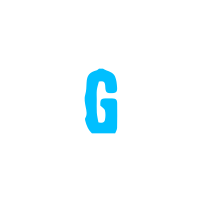

In [39]:
svg.draw_colored()

## Rotation and grid displaying

Here is a code sample showing how one can duplicate an existing icon, rotate it and display both icons side-by-side.

In [17]:
clock = SVG.load_svg("docs/imgs/clock.svg")
clock2 = clock.copy().rotate(Angle(45))
clock3 = clock.copy().rotate(Angle(90))

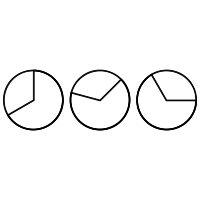

In [18]:
make_grid([clock, clock2, clock3]).draw()

## Manipulating individual paths

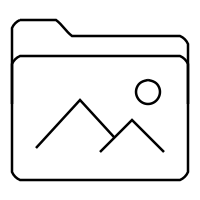

In [19]:
canvas = SVG.load_svg("docs/imgs/canvas.svg")
canvas.draw()

Let us scale the mountain on the right and translate the sun to the left.

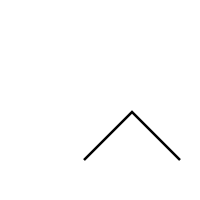

In [20]:
mountain2 = canvas[4]
center = mountain2.bbox().center
mountain2.translate(-center).scale(1.5).translate(center).draw()

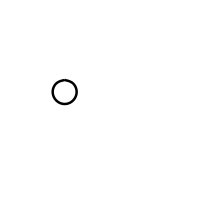

In [21]:
sun = canvas[1]
sun.translate(Point(-10, 0)).draw()

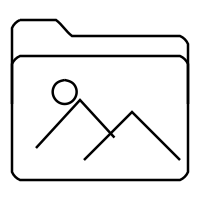

In [22]:
canvas.draw()

## Conversion to PyTorch tensor-format

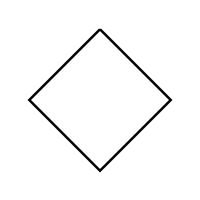

In [23]:
square = SVG.unit_square().normalize().zoom(0.5).rotate(Angle(45))
square.draw()

In [24]:
t = square.copy().numericalize().to_tensor()
t

tensor([[  0.,  -1.,  -1.,  -1.,  -1.,  -1., 128.,  37.,  -1.,  -1.,  -1.,  -1.,
         128.,  37.],
        [  1.,  -1.,  -1.,  -1.,  -1.,  -1., 128.,  37.,  -1.,  -1.,  -1.,  -1.,
         219., 128.],
        [  1.,  -1.,  -1.,  -1.,  -1.,  -1., 219., 128.,  -1.,  -1.,  -1.,  -1.,
         128., 219.],
        [  1.,  -1.,  -1.,  -1.,  -1.,  -1., 128., 219.,  -1.,  -1.,  -1.,  -1.,
          37., 128.],
        [  1.,  -1.,  -1.,  -1.,  -1.,  -1.,  37., 128.,  -1.,  -1.,  -1.,  -1.,
         128.,  37.]])

`to_tensor` converts the `SVG` instance to a PyTorch tensor of shape $N_C \times (1 + 13)$, representing the $N_C$ commands that constitute the SVG path. If the SVG has more than one path, commands will either be concatenated or `to_tensor` will output a list of tensors.
- the first row represents the command type (`m`, `l`, `c`, `a`, `EOS`, `SOS` or `z`)
- the 13 subsequent rows represent respectively: $r_x$, $r_y$, $\varphi$, $f_A$, $f_S$, $x_1$, $y_1$, $q_{x1}$, $q_{y1}$, $q_{x2}$, $q_{y2}$, $x_2$ and $y_2$. Note that the first 5 rows are for a potential future compatiblity with elliptical arc commands, but aren't used in general.

As described in the paper, unused arguments are encoded as -1.

After numericalization, coordinates are between 0 and 255.

In [25]:
from deepsvg.difflib.tensor import SVGTensor
tensor = SVGTensor.from_data(t)

`SVGTensor` is a wrapper around this PyTorch raw data, and allows for easy padding/EOS/SOS processing as well as differentiable sampling of points along the path contours. More details in the `notebooks/svgtensor.ipynb` notebook!